In [1]:
#import mathematics statics libraries
import numpy as np
import pandas as pd

#import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

#import machine learning deep learning libraries
import tensorflow as tf
from tensorflow import keras


In [2]:
#load mnist datasets
(inp_tn, out_tn), (inp_ts, out_ts) = keras.datasets.mnist.load_data()


11501568/11490434 [==============================] - 0s 0us/step


In [3]:
#expand mnist dimensions
inp_tn = inp_tn.reshape(-1,28,28,1)
inp_ts = inp_ts.reshape(-1,28,28,1)


In [4]:
#create model function
def create_model(inp_shape,
                 conv_layers_num, conv_filters, conv_kernel_size,
                 dense_layers_num, dense_drop_ratio, dense_units,
                 out_drop_ratio, out_units, out_activation,
                 optimizer, loss , metric,
                 #layers batch drop configuration
                 conv_base = True, dense_head = True,
                 batch_norm_conv = True, batch_norm_dense = True, batch_norm_out = True,
                 drop_dense = True, drop_out = True,
                 #layers activation
                 conv_activation = 'relu', dense_activation = 'relu'):
    
    model = keras.Sequential()
    
    #define input layer
    model.add(keras.layers.InputLayer(input_shape = inp_shape))

    #define convolution layers
    if conv_base:
        for i in range(conv_layers_num):
            if batch_norm_conv:
                model.add(keras.layers.BatchNormalization())
            model.add(keras.layers.Conv2D(filters = conv_filters[i],
                                          kernel_size = conv_kernel_size[i], activation = conv_activation,
                                          kernel_initializer = keras.initializers.HeNormal()))
            model.add(keras.layers.MaxPool2D())

    #convert two dims to one dim
    model.add(keras.layers.Flatten())

    #define dense layers
    if dense_head:
        for i in range(dense_layers_num):
            if batch_norm_dense:
                model.add(keras.layers.BatchNormalization())
            if drop_dense:
                model.add(keras.layers.Dropout(dense_drop_ratio[i]))
            model.add(keras.layers.Dense(units = dense_units[i], activation = dense_activation,
                                         kernel_initializer = keras.initializers.HeNormal()))

    #define output layers
    if batch_norm_out:
        model.add(keras.layers.BatchNormalization())
    if drop_out:
        model.add(keras.layers.Dropout(out_drop_ratio))
    model.add(keras.layers.Dense(units = out_units, activation = out_activation))

    #define model compile
    model.compile(optimizer = optimizer,
                  loss = loss,
                  metrics = metric)

    return model


In [5]:
#define custom callbacks
class callback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs = None):
        if logs['accuracy'] >= 0.9990 or logs['val_accuracy'] >= 0.9990 :
            self.model.stop_training = True


In [6]:
model = create_model(inp_shape=(28,28,1),
                     conv_layers_num = 2, conv_filters = [128, 128], conv_kernel_size = [3, 3],
                     dense_layers_num = 2, dense_drop_ratio = [0.3, 0.3], dense_units = [256, 256],
                     #use both dense head and convolution base
                     conv_base = True, dense_head = True,
                     out_drop_ratio = 0.3, out_units = 10, out_activation = 'softmax',
                     optimizer = 'adam', loss = 'sparse_categorical_crossentropy' , metric = 'accuracy',
                     batch_norm_conv = True, batch_norm_dense = True, batch_norm_out = True,
                     drop_dense = False, drop_out = False,)


In [7]:
#print model summary
model.summary(120)


Model: "sequential"
________________________________________________________________________________________________________________________
 Layer (type)                                         Output Shape                                    Param #           
 batch_normalization (BatchNormalization)             (None, 28, 28, 1)                               4                 
                                                                                                                        
 conv2d (Conv2D)                                      (None, 26, 26, 128)                             1280              
                                                                                                                        
 max_pooling2d (MaxPooling2D)                         (None, 13, 13, 128)                             0                 
                                                                                                                        
 batch_norma

In [8]:
#fit model for training
history = model.fit(x = inp_tn, y = out_tn, epochs = 100, batch_size = 64, validation_data = (inp_ts, out_ts),
                    callbacks = [keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience = 10, restore_best_weights = True),
                                 keras.callbacks.CSVLogger('Logs.csv'), callback()])


Epoch 1/100
938/938 [==============================] - 262s 276ms/step - loss: 0.0957 - accuracy: 0.9712 - val_loss: 0.0378 - val_accuracy: 0.9878
Epoch 2/100
938/938 [==============================] - 248s 264ms/step - loss: 0.0379 - accuracy: 0.9877 - val_loss: 0.0344 - val_accuracy: 0.9897
Epoch 3/100
938/938 [==============================] - 250s 267ms/step - loss: 0.0307 - accuracy: 0.9900 - val_loss: 0.0284 - val_accuracy: 0.9912
Epoch 4/100
938/938 [==============================] - 249s 266ms/step - loss: 0.0224 - accuracy: 0.9927 - val_loss: 0.0326 - val_accuracy: 0.9906
Epoch 5/100
938/938 [==============================] - 252s 269ms/step - loss: 0.0198 - accuracy: 0.9936 - val_loss: 0.0349 - val_accuracy: 0.9890
Epoch 6/100
938/938 [==============================] - 253s 270ms/step - loss: 0.0152 - accuracy: 0.9952 - val_loss: 0.0351 - val_accuracy: 0.9887
Epoch 7/100
938/938 [==============================] - 254s 271ms/step - loss: 0.0147 - accuracy: 0.9952 - val_loss: 0

In [9]:
#plot training history
hist_frame = pd.DataFrame(history.history)


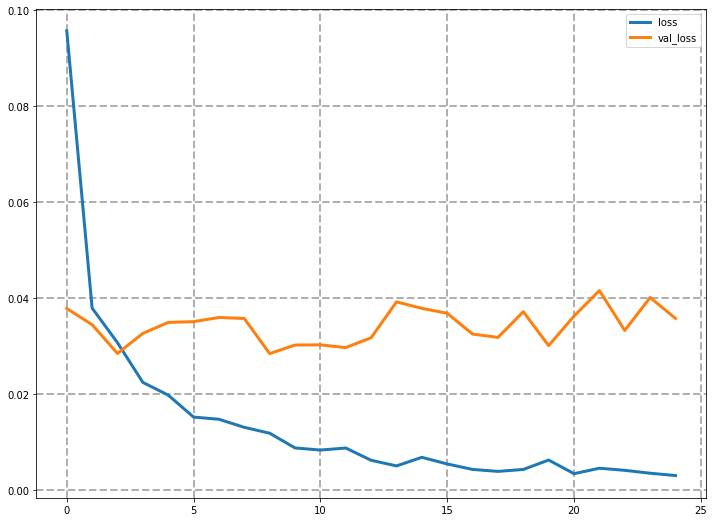

In [10]:
#plot loss
hist_frame[['loss', 'val_loss']].plot(figsize = (12,9), linewidth = 3)
plt.grid(linewidth = 2, linestyle = '--')


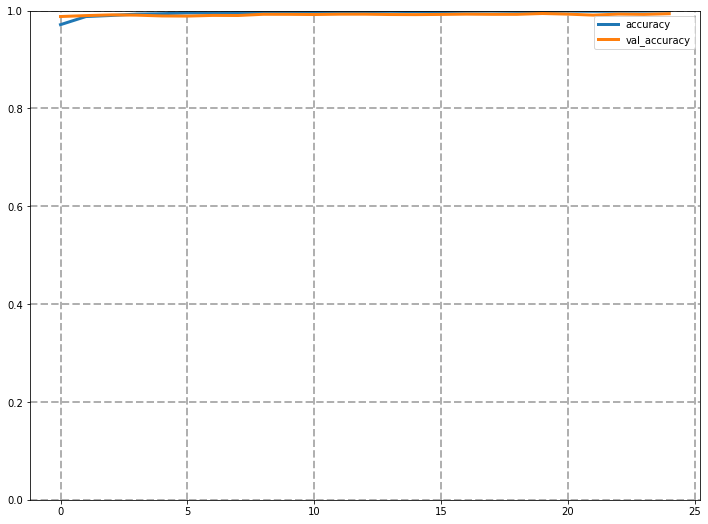

In [11]:
#plot accuracy
hist_frame[['accuracy', 'val_accuracy']].plot(figsize = (12,9), linewidth = 3)
plt.ylim(0,1)
plt.grid(linewidth = 2, linestyle = '--')


In [12]:
np.set_printoptions(linewidth = 320)

#print model test prediction
pred_ts = pd.DataFrame(model.predict(inp_ts))
count_pred_ts = (pred_ts.idxmax(axis = 1) == out_ts).value_counts()
print(count_pred_ts)

#print model test correct value counts
pred_ts.values

True     9936
False      64
dtype: int64


array([[7.38791146e-12, 1.47016097e-08, 5.61580053e-11, ..., 1.00000000e+00, 4.57950836e-14, 1.08044004e-10],
       [1.04060103e-08, 1.37337581e-08, 9.99999881e-01, ..., 3.78798763e-11, 2.33392244e-13, 2.85041435e-11],
       [1.72902543e-11, 1.00000000e+00, 1.01873388e-11, ..., 5.68786407e-11, 3.74465948e-13, 2.96095173e-14],
       ...,
       [3.21563361e-18, 9.83041299e-14, 1.08732148e-15, ..., 1.42688067e-13, 2.13721354e-14, 1.57820754e-14],
       [7.54221514e-14, 5.83980248e-17, 1.17590302e-16, ..., 1.18669953e-13, 3.93139861e-12, 4.20814571e-17],
       [1.75479700e-11, 3.79694470e-10, 1.32247124e-09, ..., 5.39547365e-11, 5.13841955e-11, 9.18740195e-10]], dtype=float32)

In [13]:
np.set_printoptions(linewidth = 320)

#print model train prediction
pred_tn = pd.DataFrame(model.predict(inp_tn))
count_pred_tn = (pred_tn.idxmax(axis = 1) == out_tn).value_counts()
print(count_pred_tn)

#print model train correct value counts
pred_tn.values

True     59994
False        6
dtype: int64


array([[1.45847119e-11, 3.27208882e-09, 7.82244842e-12, ..., 6.22675300e-10, 1.85217230e-10, 6.75225284e-12],
       [1.00000000e+00, 6.07326553e-14, 1.24376974e-12, ..., 1.18310146e-17, 8.15458595e-13, 1.15116369e-12],
       [1.89438409e-10, 4.69210781e-10, 3.48439860e-10, ..., 2.78176115e-12, 7.63443941e-14, 1.56023978e-11],
       ...,
       [2.28621757e-11, 5.77045252e-11, 1.72614039e-13, ..., 5.09846124e-11, 1.62319228e-10, 1.26447380e-10],
       [7.53977783e-12, 3.12195674e-08, 5.83442405e-10, ..., 7.09340711e-11, 5.61564467e-13, 2.44478418e-12],
       [1.86756281e-14, 9.75951279e-18, 3.47920373e-11, ..., 2.19989175e-19, 1.00000000e+00, 1.08204997e-15]], dtype=float32)

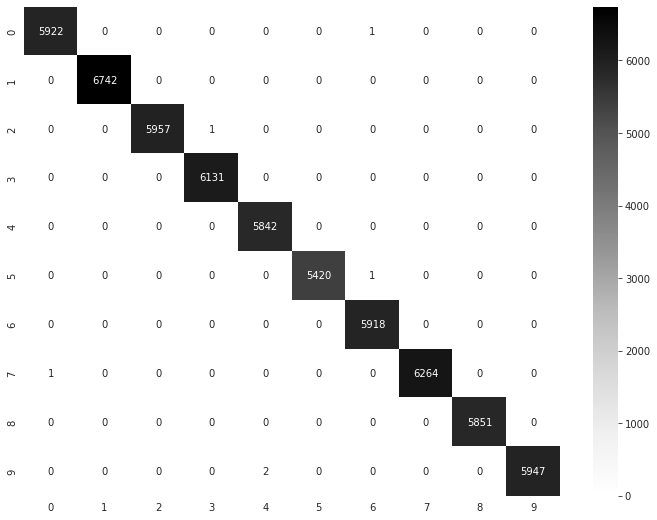

In [14]:
#plot confusion matrix
from sklearn.metrics import confusion_matrix

plt.figure(figsize = (12,9))
sns.set_style('dark')
sns.heatmap(confusion_matrix(out_tn, pred_tn.idxmax(axis = 1)),
            annot = True, fmt = '.0f', cmap = 'Greys')


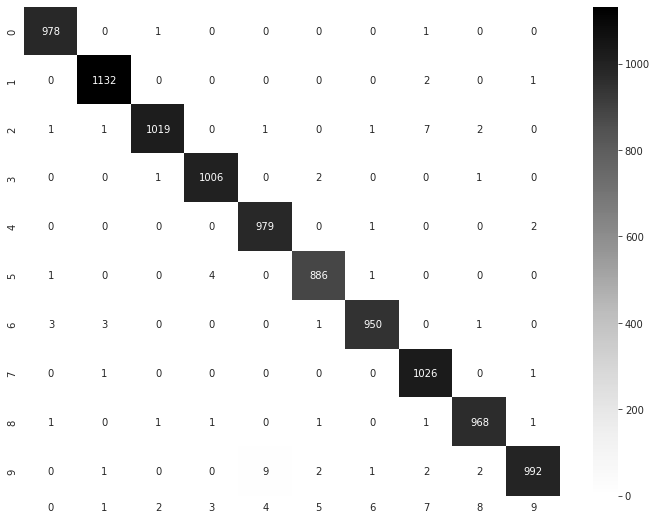

In [15]:
#plot confusion matrix
from sklearn.metrics import confusion_matrix

plt.figure(figsize = (12,9))
sns.heatmap(confusion_matrix(out_ts, pred_ts.idxmax(axis = 1)),
            annot = True, fmt = '.0f', cmap = 'Greys')


In [16]:
#save model
model.save('digits-mnist-recognition-convolution-base-dense-head.h5')
